# Контекст

- классификация твитов
- 2 класса
- model = 'cointegrated/rubert-tiny'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import time
import torch
from torch.utils.data import Dataset, DataLoader
import warnings


warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Чтение

In [2]:
train = pd.read_csv('train.csv')
train = train.dropna()
val = pd.read_csv('valid.csv')
train.head()

,text,label
0,сорри что арт просто он первый под руку попалс...,1
1,аааааа сижу на скучной паре понимая что вперед...,0
2,вкусный зеленый чай в чайнике из исинской глин...,1
3,съездили блин ничего не купили я очень расстро...,0
4,очень крутая книга читала но не дочитала на пл...,0


In [3]:
train['label'].value_counts()

label
1    29000
0    22386
Name: count, dtype: int64

# model

In [50]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification


path = 'cointegrated/rubert-tiny'
tokenizer = BertTokenizer.from_pretrained(path)
model = BertForSequenceClassification.from_pretrained(path)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [5]:
len(tokenizer.get_vocab())

29564

In [6]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

# Dataset - Dataloader

In [51]:
class RuTweetsDataset(Dataset):
    def __init__(self, tokenizer, df, max_len = 512):

        self.tokenizer = tokenizer
        self.data = df
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        text = self.data.iloc[idx]['text']
        encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens = True,
                max_length = self.max_len,
                return_token_type_ids = False,
                padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt'      
        )
        
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        labels = self.data.iloc[idx]['label']

        return {
            'text': text,
            'input_ids': torch.tensor(input_ids).flatten(),
            'attention_mask': torch.tensor(attention_mask).flatten(),
            'labels': torch.tensor(labels, dtype = torch.long)
        }

In [8]:
torch.manual_seed(42)

train_dataset = RuTweetsDataset(
    tokenizer = tokenizer,
    df = train
)

val_dataset = RuTweetsDataset(
    tokenizer = tokenizer,
    df = val
)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True,
    drop_last = True  
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False,
    drop_last = True  
)

# Проверка Dataloader

In [9]:
for batch in train_dataloader:
    batch = batch
    break

In [10]:
input_ids = batch['input_ids']
attention_mask = batch['attention_mask']
labels = batch['labels']

In [11]:
input_ids.shape

torch.Size([32, 512])

In [12]:
model.eval()
outputs = model(input_ids, attention_mask)

In [13]:
outputs[0].shape

torch.Size([32, 2])

In [14]:
loss_function = torch.nn.CrossEntropyLoss()
loss_exit = loss_function(outputs[0], labels)
loss_exit.item()

0.702978253364563

# reg / metric 

In [52]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg



def create_folder(name):
    import os
    os.mkdir(name)


from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)

def compute_metrics(output, y_true):

    y_true = y_true.detach().cpu().numpy()
    y_pred = torch.argmax(output, dim = 1).detach().cpu().numpy()
    Precision, Recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average = 'macro'
    )
    acc = accuracy_score(y_true, y_pred)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': Precision,
        'Recall': Recall
    }

# training loop

In [53]:
def training_loop(
        # папка сохранения
        name_model_folder,
        # основные настройки
        epoches,
        model,
        optimizer,
        loss_fn,
        train_dataloader,
        val_dataloader,
        # regulizer
        regulizer_append,
        reg_type,
        # verbose
        verbose_epoch
        ):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    create_folder(name_model_folder)

    batch_data = {
           'epoch_number': [],
           'train_loss': [],
           'val_loss': [],
           'train_accuracy' : [],
           'train_f1': [],
           'train_precision': [],
           'train_recall': [],
           'val_accuracy' : [],
           'val_f1': [],
           'val_precision': [],
           'val_recall': []
    }

    best_loss = float('inf')
    start_index = 0
    model = model.to(device)

    for epoch in range(1, epoches+1):
        
        loss_train_summarize = 0.0
        loss_val_summarize = 0.0
        
        start_time = time.time()

        for batch in train_dataloader:
                
                model.train()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)[0]

                # Тренировочный потери
                loss = loss_fn(outputs, labels.long())
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                        
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train_summarize += loss.item()

                batch_metrics_slovar_train = compute_metrics(outputs, labels)

                batch_data['epoch_number'].append(epoch)
                batch_data['train_loss'].append(loss.item())
                batch_data['train_accuracy'].append(batch_metrics_slovar_train['Accuracy'])
                batch_data['train_f1'].append(batch_metrics_slovar_train['F1'])
                batch_data['train_precision'].append(batch_metrics_slovar_train['Precision'])
                batch_data['train_recall'].append(batch_metrics_slovar_train['Recall'])
                #####################################################
        mean_epoch_loss_train = loss_train_summarize / len(train_dataloader)
        # Проверочный этап
        model.eval()
        with torch.no_grad():
                for batch in val_dataloader:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        outputs = model(input_ids, attention_mask)[0]
                        loss_on_val = loss_fn(outputs, labels.long())

                        # tepoch_val.set_postfix(loss=loss_on_val.item())

                        loss_val_summarize += loss_on_val.item()

                        batch_metrics_slovar_val = compute_metrics(outputs, labels)
                        
                        batch_data['val_loss'].append(loss_on_val.item())
                        batch_data['val_accuracy'].append(batch_metrics_slovar_val['Accuracy'])
                        batch_data['val_f1'].append(batch_metrics_slovar_val['F1'])
                        batch_data['val_precision'].append(batch_metrics_slovar_val['Precision'])
                        batch_data['val_recall'].append(batch_metrics_slovar_val['Recall'])

                        
                                
                
                mean_epoch_val_loss = loss_val_summarize / len(val_dataloader)
                # Сохранение состояний модели
                if mean_epoch_val_loss < best_loss:
                        best_loss = mean_epoch_val_loss
                        torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')
        ##############################################################
        end_time = time.time()
        epoch_time = end_time - start_time
        расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
        ############ VERBOSE #########################################
        if epoch == 1:
                print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
        if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss_train,
                                mean_epoch_val_loss
                                )     
                        )
    with open(f'{name_model_folder}/batch_results.json', 'w') as outfile:
        json.dump(batch_data, outfile)
        
    return model, batch_data 

# Training model_1

In [18]:
torch.manual_seed(42)

train_dataset = RuTweetsDataset(
    tokenizer = tokenizer,
    df = train
)

val_dataset = RuTweetsDataset(
    tokenizer = tokenizer,
    df = val
)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True,
    drop_last = True  
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False,
    drop_last = True  
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = torch.nn.CrossEntropyLoss()


model, results_batch  =\
training_loop(
    name_model_folder = 'model_1',
    epoches = 3,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn.to(device),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    verbose_epoch = 1
)

Расчетное время выполнения всего цикла 19.883 минут
Epoch     1/    3 || time: 397.656 || train loss: 0.588 || val_loss 0.549
Epoch     2/    3 || time: 402.860 || train loss: 0.514 || val_loss 0.537
Epoch     3/    3 || time: 402.765 || train loss: 0.455 || val_loss 0.539


In [11]:
with open('model_1/batch_results.json', 'r') as f:
    batch_results = json.load(f)

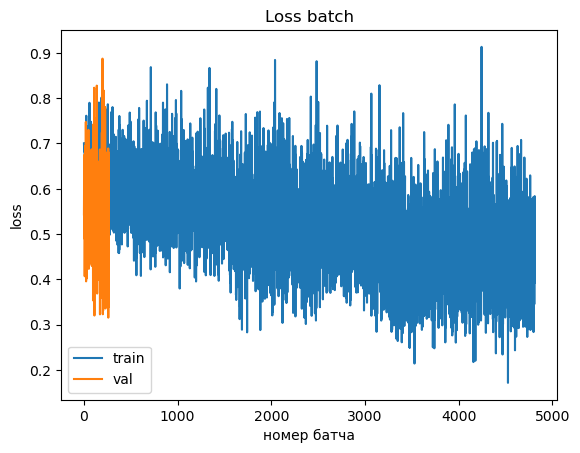

In [41]:
sns.lineplot(
    y = batch_results['loss_train'],
    x = np.arange(len(batch_results['loss_train'])),
    label = 'train'
)
sns.lineplot(
    y = batch_results['loss_val'],
    x = np.arange(len(batch_results['loss_val'])),
    label = 'val'
)
plt.xlabel('номер батча')
plt.ylabel('loss')
plt.title('Loss batch')
plt.legend()

In [14]:
def plot_results(slovar, metric):

    sns.lineplot(
    y = slovar[f'train_{metric}'],
    x = np.arange(len(slovar[f'train_{metric}'])),
    label = 'train'
    )
    sns.lineplot(
        y = slovar[f'val_{metric}'],
        x = np.arange(len(slovar[f'val_{metric}'])),
        label = 'val'
    )
    plt.ylabel(f'{metric}')
    plt.title(f'{metric}')
    plt.legend()
    plt.show()

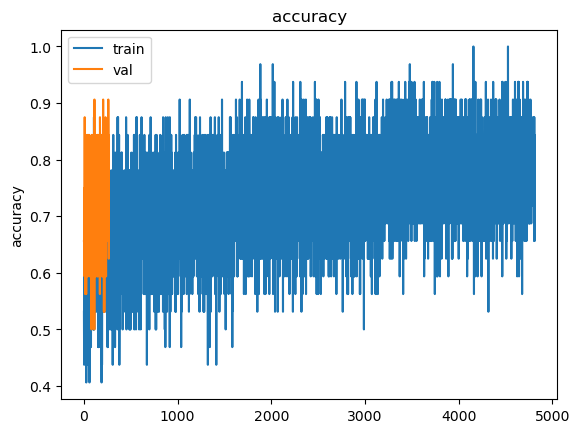

In [36]:
plot_results(batch_results, 'accuracy')

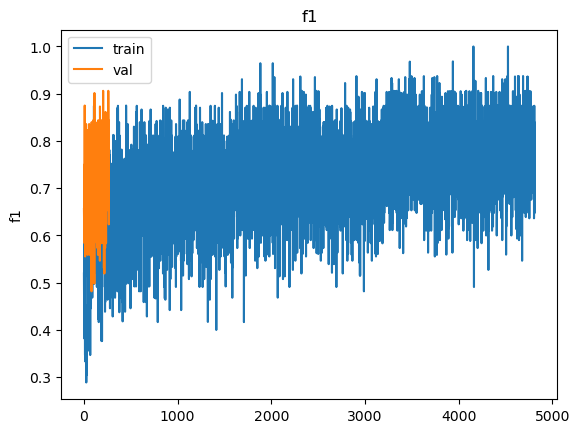

In [37]:
plot_results(batch_results, 'f1')

In [ ]:
def create_epoch_data(batch_results):

    epoch_results = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy' : [],
        'train_f1': [],
        'train_precision': [],
        'train_recall': [],
        'val_accuracy' : [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }
    for key_word in epoch_results.keys():
        batch_data = batch_results[key_word]
        for epoch_list in np.array_split(batch_data, 3):
            epoch_mean_value = np.mean(epoch_list)
            epoch_results[key_word].append(epoch_mean_value)
    
    return epoch_results

epoch_results = create_epoch_data(batch_results)

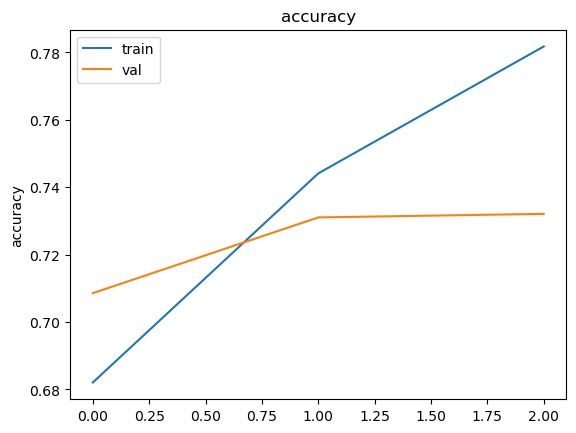

In [39]:
plot_results(epoch_results, 'accuracy')

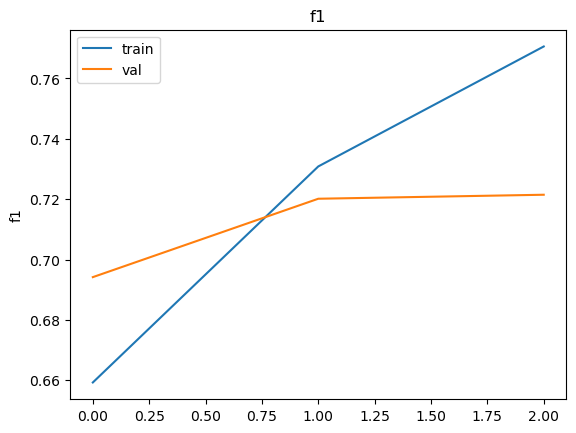

In [40]:
plot_results(epoch_results, 'f1')

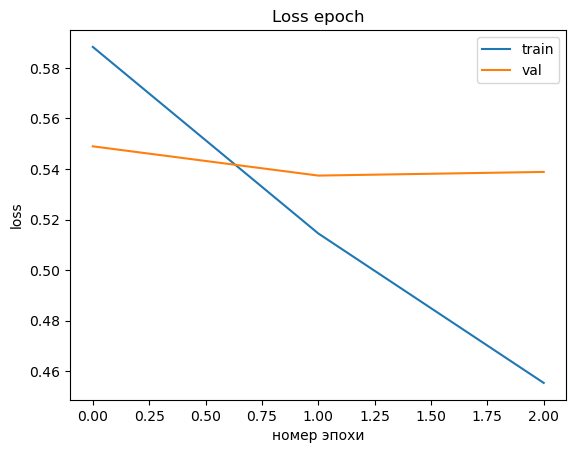

In [44]:
sns.lineplot(
    y = epoch_results['loss_train'],
    x = np.arange(len(epoch_results['loss_train'])),
    label = 'train'
)
sns.lineplot(
    y = epoch_results['loss_val'],
    x = np.arange(len(epoch_results['loss_val'])),
    label = 'val'
)
plt.xlabel('номер эпохи')
plt.ylabel('loss')
plt.title('Loss epoch')
plt.legend()

# model_2 (добавим эпох)

In [54]:
torch.manual_seed(42)

train_dataset = RuTweetsDataset(
    tokenizer = tokenizer,
    df = train
)

val_dataset = RuTweetsDataset(
    tokenizer = tokenizer,
    df = val
)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True,
    drop_last = True  
)

val_dataloader = DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False,
    drop_last = True  
)


optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005)
loss_fn = torch.nn.CrossEntropyLoss()


model, results_batch  =\
training_loop(
    name_model_folder = 'model_2',
    epoches = 5,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn.to(device),
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader,
    regulizer_append = False,
    reg_type = None,
    verbose_epoch = 1
)

Расчетное время выполнения всего цикла 27.468 минут
Epoch     1/    5 || time: 329.616 || train loss: 0.587 || val_loss 0.549
Epoch     2/    5 || time: 300.991 || train loss: 0.513 || val_loss 0.536
Epoch     3/    5 || time: 229.737 || train loss: 0.453 || val_loss 0.538
Epoch     4/    5 || time: 256.441 || train loss: 0.397 || val_loss 0.566
Epoch     5/    5 || time: 271.928 || train loss: 0.337 || val_loss 0.616


In [4]:
with open('model_2/batch_results.json', 'r') as file:
    file = json.load(file)

In [12]:
epoch_results = create_epoch_data(file)

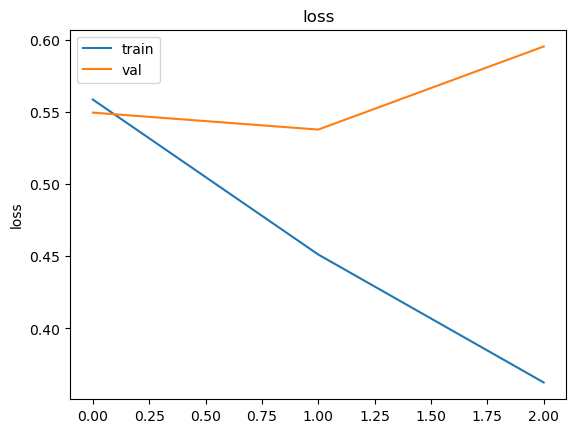

In [15]:
plot_results(epoch_results, 'loss')

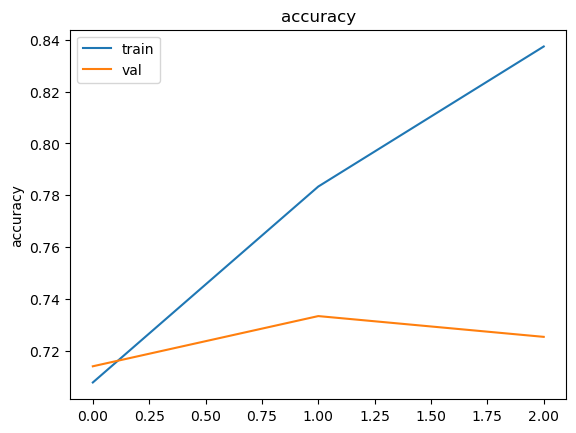

In [16]:
plot_results(epoch_results, 'accuracy')

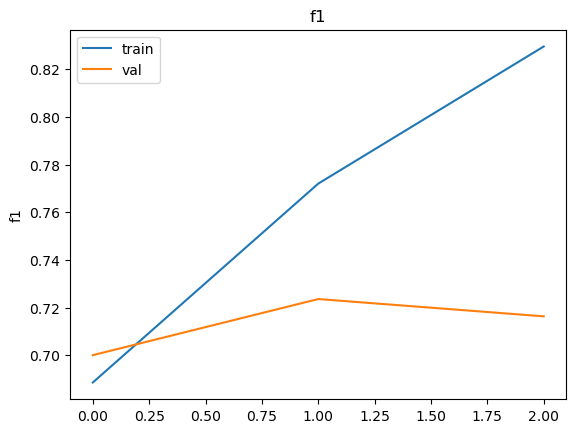

In [17]:
plot_results(epoch_results, 'f1')